In [1]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}


div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
.3
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

# Objectives

In this note book, I am testing M-H MCMC module.

   - import Metropolis_Hasting as MCMC
   - Using the same exercise in the notebook : Test_NS_with_simple_Gaussian1.0

In [2]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import corner
import copy as duplicate
import time
from matplotlib import colors
import scipy as sp


#test numba
from numba import jit , prange
####Import test mcmc module

import Metropolis_Hasting_3_0T as MH3
import Functions as F

from ipywidgets import IntProgress
from IPython.display import display

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

#####################################

In [3]:
# Useful function #Compute the log of the sum of exponentials of input elements.
# OR from scipy.misc import logsumexp 

def logsumexp(values):
    biggest = np.max(values)
    x = values - biggest
    result = np.log(np.sum(np.exp(x))) + biggest
    return result


## Simulated Data

In [4]:
Data  = pd.read_csv('example_cubic_data.txt', delimiter = ' ', names = ['x', 'y', 'err'])

x_values = Data.x
y_values = Data.y
erorr = Data.err


Text(0,0.5,'y')

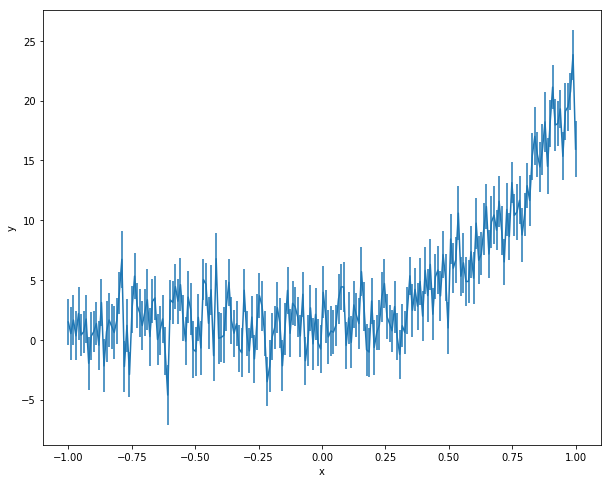

In [5]:
plt.figure(figsize=(10,8))
plt.errorbar(x_values, y_values, yerr=erorr)
plt.xlabel('x')
plt.ylabel('y')

# Generate walkers

In [6]:
def Generate_N_samples():
    """Draw a sample from a uniform prior distribution for each parameter"""
    
    a = sp.stats.uniform.rvs(0,30)
    b = sp.stats.uniform.rvs(0,20)
    c = sp.stats.uniform.rvs(0,20)
    d = sp.stats.uniform.rvs(0,20)
    
    sample = np.array([a,b,c,d])
    
    return sample

In [287]:
# Generate walkers
N = 600


#LIMITS of mu
mulimits = np.array([[0,30],[0,20],[0,20],[0,20]])

#Likelihood function arguments
args_loglike = [y_values, erorr, x_values]

#Prior function arguments
args_prior = np.array(mulimits)

logl = np.array([])
logp = np.array([])

#particles
particles = np.zeros((N,len(mulimits)))

for i in prange(N):
    mu_val       = Generate_N_samples()
    particles[i] = mu_val
    logl         = np.append(logl, F.logLikelihood_cubic(mu_val,args_loglike)) 
    logp         = np.append(logp, F.Prior(mu_val,args_prior))

In [288]:
# Number of NS iterations
nest_steps = 5000

# MCMC steps per NS iteration
mcmc_steps = 80

# mcmc stepsize
param_step =  [.5,.4,.3,.2] 
stepsize = np.array(param_step) 

#Number of parameters
num_params = 4



# Storage for results
keep = np.empty((nest_steps, num_params + 1))

nacceptance = np.array([])
nrejectance = np.array([])



# Main Nest

In [289]:
start = time.time()
for i in prange(nest_steps):
    
    # Particle with worst likelihood
    worst = np.argmin(logl)   
    
    # Save the details of the worst particle, (likelihood)
    keep[i,:-1] = particles[worst] 
    keep[i,-1]  = logl[worst]
    
    # Copy random survivor
    #----copy a random point and do mcmc from there-----
    copy = np.random.choice(np.concatenate(\
               (np.arange(1,worst),np.arange(worst+1,len(particles)))))
            
    # Throw away worst particle and replace with random particle 
    #and do mcmc from the random particle (will change with new sample)
    #particles[worst] = duplicate.deepcopy(particles[copy]) 
    
    particle_new_copy =  particles[copy]
    
    # Likelihood of worst point
    loglstar = logl[worst]
    logpstar = logp[worst]
    
    
    theta = particle_new_copy
    
    #Do mcmc on the survivor particle
    chain_particle , chain_loglike , chain_prior , Acceptance_R = MH3.MH_mcmc(F.logLikelihood_cubic,F.Prior,\
                                                    theta,args_loglike,args_prior,mcmc_steps,stepsize)
    if max(chain_loglike) >loglstar:
        
        # accept sample with higher likelihood than the 
        logl[worst]      = max(chain_loglike)                    
        particles[worst] = duplicate.deepcopy(chain_particle[np.argmax(chain_loglike)])
        logp[worst]      = chain_prior[np.argmax(chain_loglike)]
       
        #Save acceptance ratio for each mcmc
        nacceptance = np.append(nacceptance,Acceptance_R)

        
    
end = time.time()
print("time (s): ", end - start)

time (s):  1022.1476838588715


In [277]:
#Prior Mass    
logX = -(np.arange(0, (nest_steps))+ 1.)/N

# Prior width  wi = 0.5(Xi-1 Xi+1)
logPrior_width = np.array([0.5*(logX[i]-logX[i+1]) for i in range(len(logX)-1)])

logPrior_width = np.append(logPrior_width,0.5*logX[-1])

# Calculate the Evidence ( marginal likelihood 
equaion 8)

logZ = logsumexp(logPrior_width + keep[:,-1])

# Posterior weights (equation 10)

logPosterior_weights = np.array([ (li+wi)-logZ for li,wi in zip(keep[:,-1],logPrior_width)])

Posterior_weights = np.exp(logPosterior_weights)

#Evaluate the information
H = int(np.exp(-np.sum(Posterior_weights*np.log(Posterior_weights + 1E-300))))

print('logZ = {logZ} '.format(logZ=logZ))
print('Information = {H} nats'.format(H=H))

 

logZ = -413.8791961278252 
Information = 3835 nats


# Acceptance Ratio

Text(0,0.5,'Acceptance Ratio')

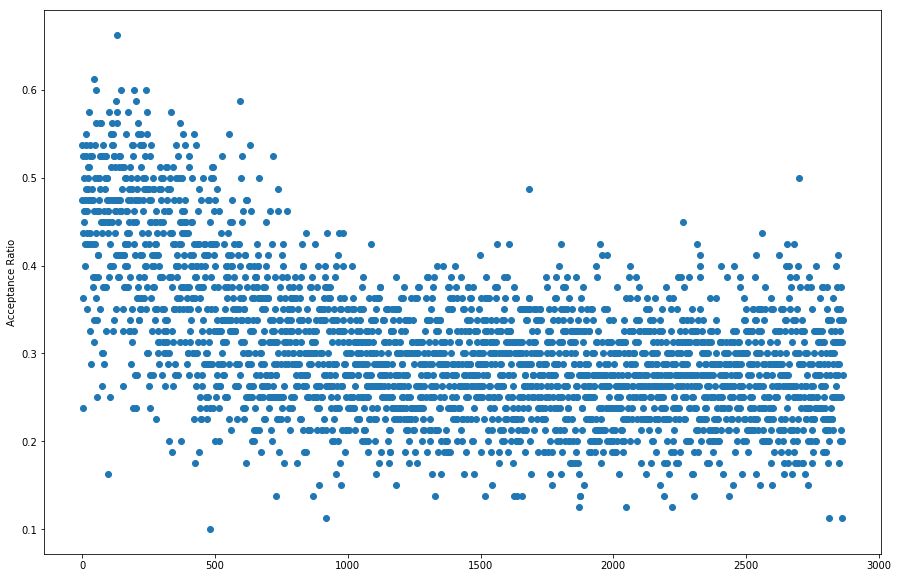

In [278]:
plt.figure(figsize=(15,10))
plt.plot(nacceptance,'o')
plt.ylabel('Acceptance Ratio')

Text(0.5,0,'$log(X)$')

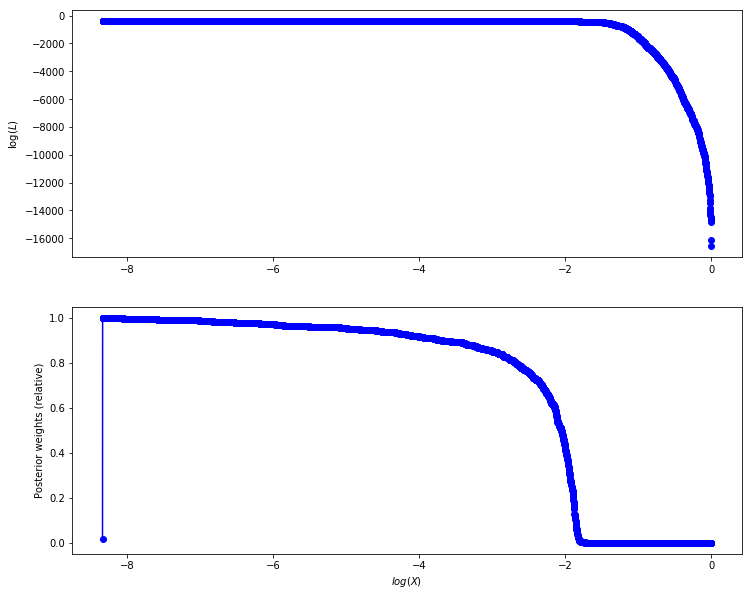

In [279]:
#Visualize Likelihood vs Prior Mass
fig, (ax1, ax2) = plt.subplots(figsize=(12,10),nrows=2)

ax1.plot(logX, keep[0:(nest_steps), -1], 'bo')
ax1.set_ylabel('$\\log(L)$')
      
ax2.plot(logX, Posterior_weights/Posterior_weights.max(), 'bo-')
ax2.set_ylabel('Posterior weights (relative)')
ax2.set_xlabel('$log(X)$')

# Posterior

In [280]:
posterior_samples = np.empty((H, keep.shape[1]))
k = 0
while True:
  # Choose one of the samples
    which = np.random.randint(keep.shape[0])

  # Acceptance probability
    prob = Posterior_weights[which]/Posterior_weights.max()

    if np.random.rand() <= prob:
        posterior_samples[k, :] = keep[which, :]
    
        k += 1

    if k >= H:
        break

#np.savetxt('keep_Many.txt', posterior_samples)

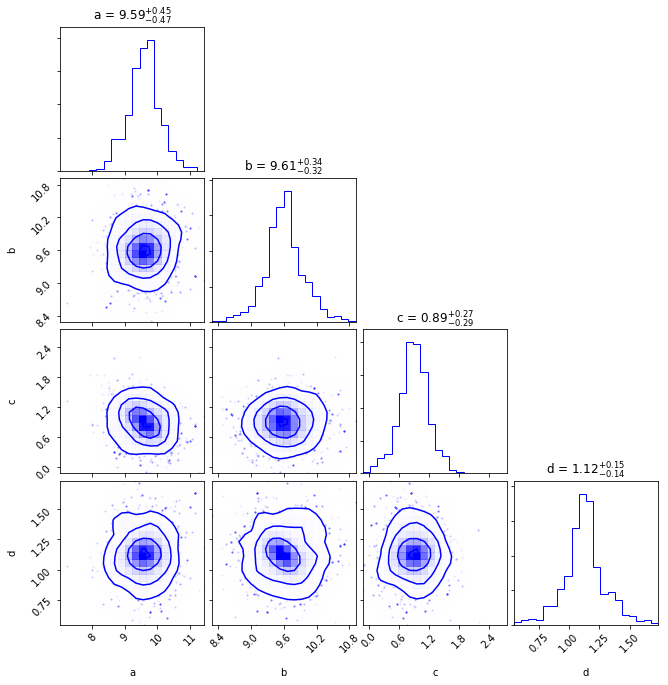

In [281]:
Fig = corner.corner(posterior_samples[:,:-1], labels=['a','b','c','d'],bins=20,show_titles=True,color='b',smooth=1.0);

In [282]:
#MEAN values
a = np.mean(posterior_samples[:,0])
b = np.mean(posterior_samples[:,1])
c = np.mean(posterior_samples[:,2])
d = np.mean(posterior_samples[:,2])

In [283]:
a,b,c,d

(9.58926153645029, 9.609608688291733, 0.8883641459601492, 0.8883641459601492)

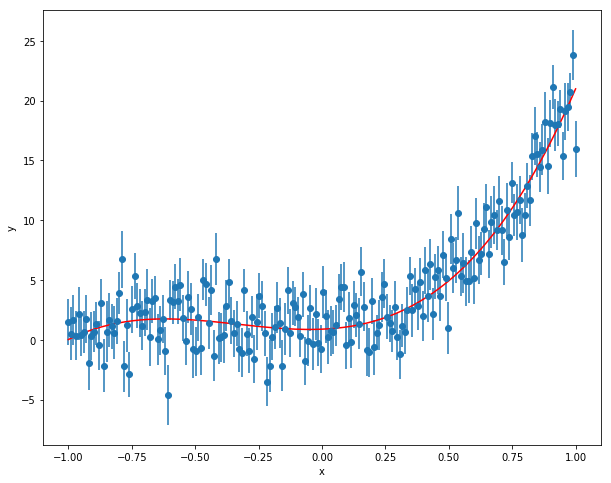

In [284]:
y_mod = F.model_equation_cubic([a,b,c,d],x_values)

plt.figure(figsize=(10,8))
plt.plot(x_values,y_mod,'r')
plt.errorbar(x_values, y_values, yerr = erorr, fmt='o')
plt.xlabel('x')
plt.ylabel('y')
#plt.savefig('fit')
plt.show()

# LogZ Distribution

In [285]:
logZ_distribution = []  #Empty list to store logZ
NZ = 5000               # LlogZ sample size

for i in range(NZ):   # Samples size
    uniform_numbers = np.log(np.random.uniform(0,1,len(keep[:,-1])))  #Generate log uniform numbers (log space)
    number_new = 0                                                    #initialize number
    logX_mass = []                                                    #store each prior mass

    for number in uniform_numbers:                                    # for each log uniform number
    
        number_new += number                                         # x1,x2,x3 = u1,u1*u2,u1*u2*u3 etc. in log space we add
        logX_mass.append(number_new/N)                              # store each logx.
        
    # Prior width
    logPrior_width_un = np.array([0.5*(logX_mass[i]-logX_mass[i+1])\
                                  for i in range(len(logX_mass)-1)])

    logPrior_width_un = np.append(logPrior_width_un,0.5*logX_mass[-1])
    

    logZ_un = logsumexp(logPrior_width_un + keep[:,-1])                        #Evaluate logZ 
    
    logZ_distribution.append(logZ_un)                                #store each logZ 
    

Text(0.5,0,'LogZ')

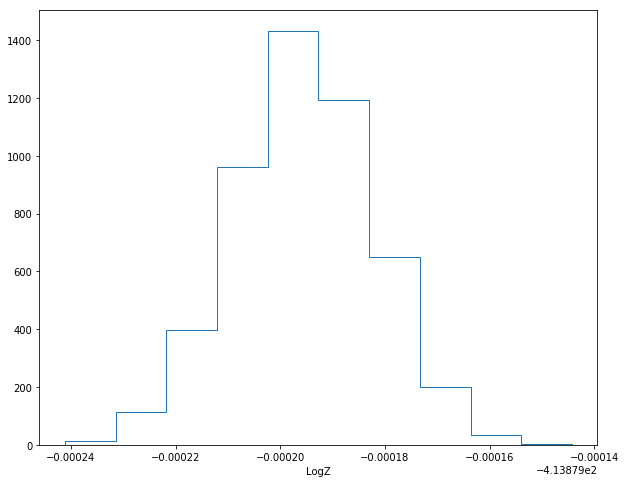

In [286]:
std = np.std(logZ_distribution)    # Standard deviation of logZ distribution

fig,ax = plt.subplots(figsize=(10,8),nrows=1)

ax.hist(logZ_distribution,histtype='step');
ax.set_xlabel('LogZ')